In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import yeast_name_resolver 
from collections import defaultdict
import seaborn as sns
import scipy.stats as stats

In [35]:

plt.rcParams["font.family"] = "Liberation Serif"
plt.rcParams["font.weight"] = "bold"
plot_cfg = {
    "tick_label_size" : 50,
    "xlabel_size" : 60,
    "ylabel_size" : 60,
    "border_size" : 6,
    "bar_border_size" : 2.5,
    "bar_label_size" : 32,
    "stars_label_size" : 48,
    "annot_size" : 72,
    "max_cm_classes" : 4,
    "legend_size" : 42,
    "max_bars" : 4
}

In [4]:
task_df = pd.read_csv('../generated-data/task_yeast_gi_hybrid')

In [5]:
res = yeast_name_resolver.NameResolver()

def read_blastp_results(path, get_name_func):

    results = defaultdict(list)

    with open(path, 'r') as f:

        for line in f:
            query, subject, nident, positive, mismatch, gaps, gapopen, length, pident, ppos, evalue, bitscore = line.strip().split('\t')

            query = get_name_func(query)
            subject = get_name_func(subject)

            if query == subject:
                continue

            results[query].append({
                'subject': subject,
                'pident' : float(pident),
                'ppos' : float(ppos),
                'evalue' : float(evalue),
                'bitscore' : float(bitscore)
            })

    return results

def yeast_get_name(s):
    return res.get_unified_name(s)

In [41]:
results = read_blastp_results('../tmp/blastp_yeast', yeast_get_name)
len(results)

3441

In [9]:
genes_a = list(task_df['a'])
genes_b = list(task_df['b'])
bins = list(task_df['bin'])

In [10]:
homologs = np.zeros(task_df.shape[0])
i = 0
for a, b, gibin in zip(genes_a, genes_b, bins):
    
    if a in results:
        subjects = [r['subject'] for r in results[a]]
        if b in subjects:
            homologs[i] = 1
    elif b in results:
        subjects = [r['subject'] for r in results[b]]
        if a in subjects:
            homologs[i] = 1
    
    i = i + 1

In [26]:
gi_bins = task_df['bin'] != 1
net_bins = ~gi_bins
homologs = homologs.astype(bool)

In [36]:
R = np.array([
    [np.sum(gi_bins & ~homologs), np.sum(gi_bins & homologs)],
    [np.sum(net_bins & ~homologs), np.sum(net_bins & homologs)],
])


def chi2(f_obs):

    # compute expected frequencies
    col_marginal = np.sum(f_obs, axis=1, keepdims=True)
    row_marginal = np.sum(f_obs, axis=0, keepdims=True)
    total = np.sum(row_marginal)
    f_exp = np.dot(col_marginal / total, row_marginal)
    
    
    print(f_obs)
    print(col_marginal)
    print(row_marginal)
    print(f_exp)
    
    chisq, p = stats.chisquare(f_obs, f_exp, axis=None)
    
    ddof = (f_obs.shape[0]-1) * (f_obs.shape[1]-1)

    return chisq, p, ddof

chisq, p, ddof = chi2(R)
print(chisq, ' ', p)


[[  20832     476]
 [6890273    7289]]
[[  21308]
 [6897562]]
[[6911105    7765]]
[[2.12840862e+04 2.39138212e+01]
 [6.88982091e+06 7.74108618e+03]]
8582.636505795528   0.0


[[0.00301428 0.06130071]
 [0.99698572 0.93869929]]


[None, None, None, None, None, None, None, None]

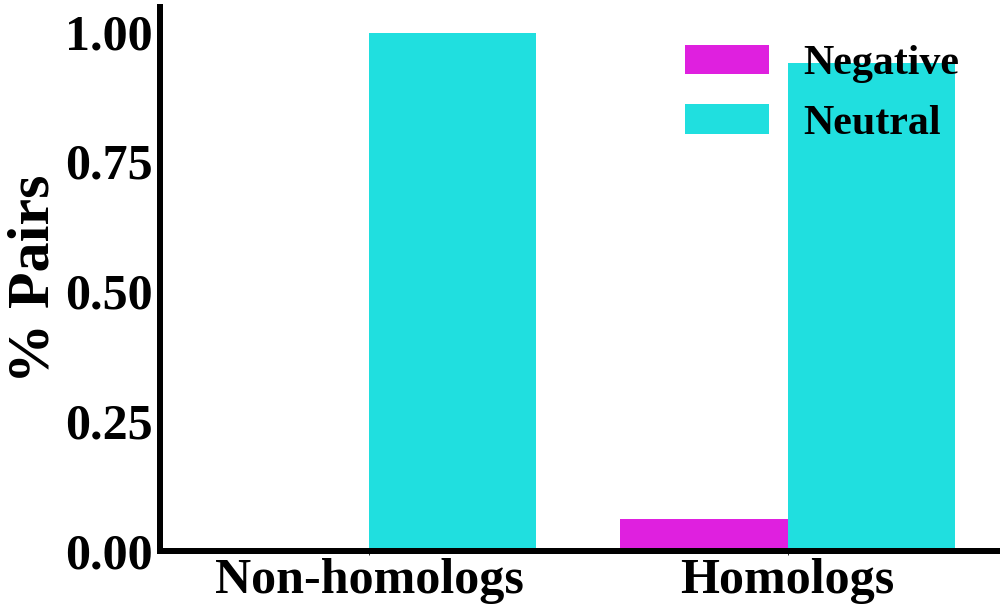

In [39]:
print(R / np.sum(R, axis=0, keepdims=True))
rows = []
bin_labels = ['Negative', 'Neutral']
for thebin in range(R.shape[0]):
    for k, lbl in enumerate(['Non-homologs', 'Homologs']):
        rows.append({
            "bin" : bin_labels[thebin],
            "hom" : lbl,
            "freq" : R[thebin, k] / np.sum(R[:,k])
        })
df = pd.DataFrame(rows)
f, ax = plt.subplots(1, 1, figsize=(15, 10))
g = sns.barplot(x="hom", 
        y="freq", 
        hue="bin",
        ax=ax,
        data=df, 
        palette=['magenta', 'cyan'])


ax.yaxis.set_tick_params(labelsize=plot_cfg['tick_label_size'])
ax.xaxis.set_tick_params(labelsize=plot_cfg['tick_label_size'])
ax.set_ylabel("% Pairs", fontsize=plot_cfg['ylabel_size'], fontweight='bold')
ax.set_xlabel("", fontsize=plot_cfg['ylabel_size'], fontweight='bold')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(frameon=False, fontsize=plot_cfg['legend_size'])
plt.setp(ax.spines.values(),linewidth=plot_cfg["border_size"], color='black')
